<a href="https://colab.research.google.com/github/ibonetc/VisionAPI_TensorFlow_Python/blob/master/DA_Ejemplo2_Clasificar_Imagenes_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo usando Keras con la base de datos de perros y gatos

Enlace de datos: 
[Descargue la base de datos aquí](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

In [21]:
from sklearn.datasets import load_files       
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
import os

## Cargando archivos desde Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Después de poner el código de autorización de Google Drive, en el panle izuqierdo, en Archivos, podrá recorrer en la carpeta drive/My Drive todos los archivos que tiene en Drive y acceder a ellos.

Con la siguiente instrucción puede listar los archivos:

In [ ]:
!ls "/content/drive/My Drive/"

'018_5- The Official Guide to the TOEFL Test_2018, 5th -747p.pdf'
 0470511389_BI_Book_2009.pdf
'1 (1).rtf.gdoc'
 149_2040.JPG
 1.rtf.gdoc
'2013_Computación y sistemas con Isel1477-2451-1-PB.pdf'
'40209 (1).pdf'
 40209.pdf
 ActaPlytechnicaHungarica
 AdventureWorksDW2012_Data.mdf
 Agents
 ai_poster_stem2017.pdf
 AIS_Cuba.pdf
 AIS_Cuba_sig.pdf
 Analitics_Esp
 ArbolEclipse.drawio
 ArbolN.drawio
 Arwis
 Arwis_Bajo
 Arwis_Ultimo
 ASOC_3_0_.pdf
'ATT00001 (1).gdoc'
 ATT00001.gdoc
 auditory_spm12_batch.m
 AWS
'Base datos completa Cancer Oral.xlsx'
 BI
 Biblioteca.drawio
 BI_DataMining_Argos
 BigDataReview
 BI_UdeM
'Bonet_CBIO (2).pdf'
'Canciones y clasificaciones.xlsx'
'cemami1 29-ago.-2018 21-25-02.pdf'
'cemami2 29-ago.-2018 21-26-41.pdf'
'certLaboral 15-ago.-2018 16-25-03.pdf'
 CES
 CES_BigDataSalud_2017
 CIBB2019
 CIBB2019_Isis_F.pptx
'Clases BigData'
'Clases UdeM'
'Classic-computers-3_1 (1).pdf'
 Classic-computers-3_1.pdf
 Classroom
 codigos.txt
 codigos.txt.gdoc
'Colab Notebooks'
'Copy of

Como el fichero está comprimido con .zip, se ejecuta la siguiente instrucción para descomprimirlo

In [3]:
!unzip "/content/drive/My Drive/Gatos_Perros.zip"

Archive:  /content/drive/My Drive/Gatos_Perros.zip
  inflating: train.zip               
  inflating: sample_submission.csv   
  inflating: test.zip                


In [4]:
!unzip "/content/test.zip"
!unzip "/content/train.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520

In [5]:
PATH="/content"

In [ ]:
os.listdir(f'{PATH}/train')

In [11]:
fnames_train = np.array([f'{PATH}/train/{f}' for f in (os.listdir(f'{PATH}/train'))])
labels_train = np.array([(0 if 'cat' in fname else 1) for fname in fnames_train])

In [12]:
fnames_train

array(['/content/train/dog.10880.jpg', '/content/train/cat.3347.jpg',
       '/content/train/dog.8539.jpg', ..., '/content/train/cat.3020.jpg',
       '/content/train/cat.886.jpg', '/content/train/cat.8325.jpg'],
      dtype='<U28')

In [13]:
np.unique(labels_train,return_counts=True)

(array([0, 1]), array([12500, 12500]))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Gatos y Perros')

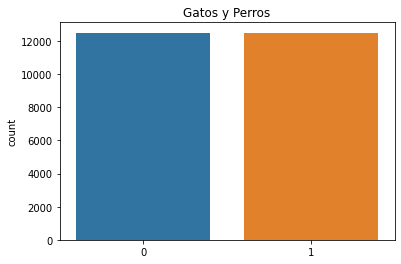

In [20]:
sns.countplot(labels_train)
plt.title('Gatos y Perros')

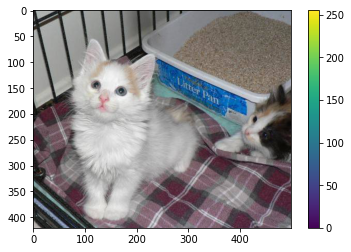

In [26]:
img = plt.imread(fnames_train[1])
plt.imshow(img)
plt.grid(False)
plt.colorbar()

In [27]:
img.shape

(421, 499, 3)

Ahora carguemos los datos de prueba

In [ ]:
fnames_test = np.array([f'{PATH}/test/{f}' for f in (os.listdir(f'{PATH}/test'))])
labels_test = np.array([(0 if 'cat' in fname else 1) for fname in fnames_test])

In [ ]:
len(fnames_test)

12500

## Creando el conjunto de entrenamiento y prueba
* Necesitamos cargar las imágenes.
* Reescalarlas, porque no tienen el mimo tamaño, por ejemplo acá vamos a ponerlas de 64x64 y con canal 3

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), 
                activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                    metrics = ['accuracy'])

In [ ]:
def read_image(file_path, ROWS = 64,COLS = 64):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS))

In [ ]:
def prep_data(images, ROWS = 64,COLS = 64,CHANNELS=3):
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS))
  for i, image_file in enumerate(images):
    image = read_image(image_file,ROWS,COLS)
    data[i] = image   
  return data

In [ ]:
ROWS = 64
COLS = 64
CHANNELS = 3
train = prep_data(fnames_train,ROWS=ROWS,COLS=COLS)

In [ ]:
train=train/255.0
test=test/255.0

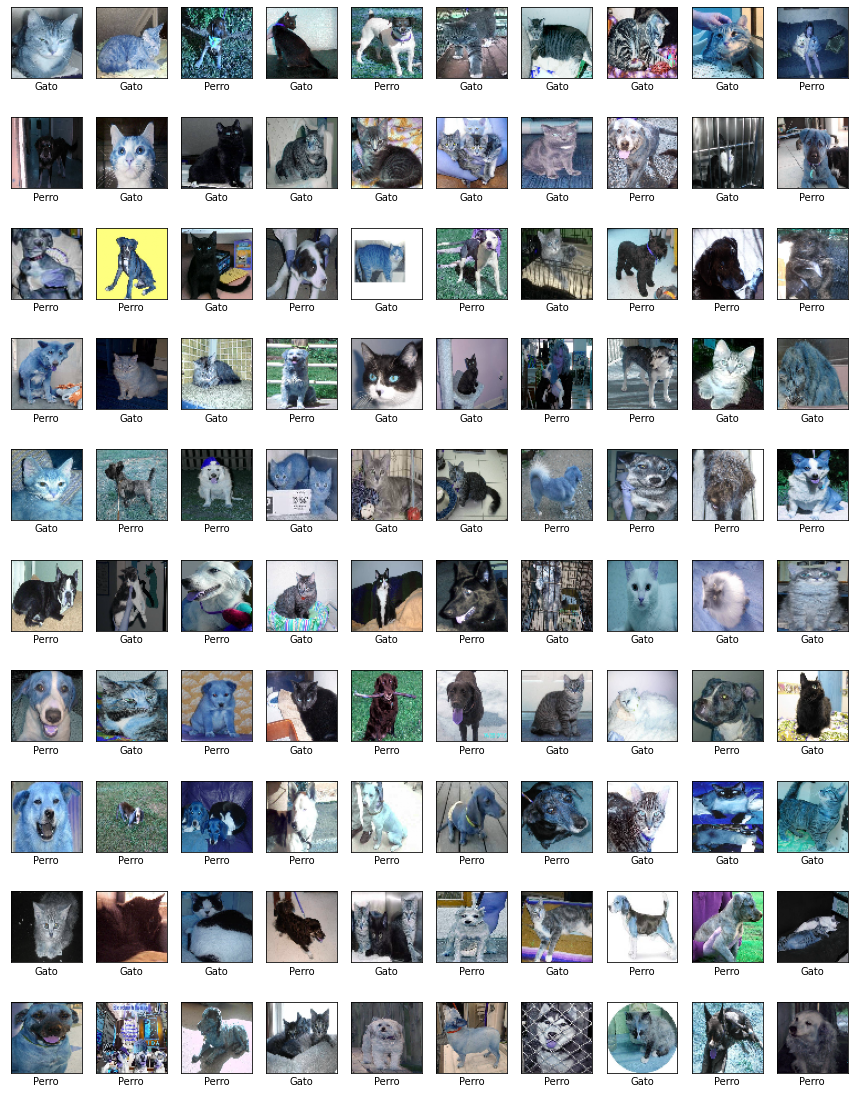

In [ ]:
plt.figure(figsize=(15,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i])
    plt.xlabel('Gato' if labels_train[i]==0 else 'Perro')
plt.show()

## Creando modelo
Definamos el siguiente modelo de red neuronal:

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Como el test no tiene labels, para poder validar el modelo vamos a dividir el entrenamiento en 80% para entrenar y 20% para validar

In [ ]:
# Dividiendo la base de train en dos: 80% para train, 20% para validación)
#test_size: proporción de datos para test, random_state: semilla para el aleatorio
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train,labels_train, test_size=0.2, random_state=7)

In [ ]:
print(len(X_train), len(X_val))

20000 5000


In [ ]:
print(np.unique(Y_train,return_counts=True),np.unique(Y_val,return_counts=True))

(array([0, 1]), array([ 9975, 10025])) (array([0, 1]), array([2525, 2475]))


Para hacer validación de los datos es bueno tener una base de validación o hacer una división de los datos para que en el entrenamiento pueda hacer validación con un porciento de los datos, para esto se puede usar la variable: ***validation_split***, asignándole una fracción entre 0 y 1.

O se puede asignar una porción de los datos, como hacemos a continuación, con la fracción de datos dividida anteriormente.

In [ ]:
#validation_data=evalúa el resultado en estos datos y no en el entrenamiento.
history=classifier.fit(X_train,Y_train, epochs = 50,validation_data=(X_val,Y_val))

Epoch 1/50
625/625 [==============================] - 4s 7ms/step - loss: 0.0575 - accuracy: 0.9809 - val_loss: 0.8693 - val_accuracy: 0.7932
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0385 - accuracy: 0.9880 - val_loss: 0.9925 - val_accuracy: 0.7860
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0428 - accuracy: 0.9859 - val_loss: 1.0025 - val_accuracy: 0.7774
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0323 - accuracy: 0.9899 - val_loss: 1.0155 - val_accuracy: 0.7792
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 1.2224 - val_accuracy: 0.7792
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0316 - accuracy: 0.9889 - val_loss: 1.1139 - val_accuracy: 0.7796
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 1.3076 - val_accuracy: 0.7760
Epoch 

In [ ]:
classifier.evaluate(X_val,Y_val)

157/157 [==============================] - 1s 3ms/step - loss: 2.3916 - accuracy: 0.7910


[2.3916468620300293, 0.7910000085830688]

Resultados del aprendizaje y la validación

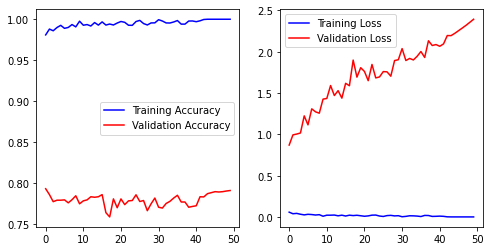

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
predictions = classifier.predict(X_val)

Text(0.5, 0, 'Gato  0% (Gato)')

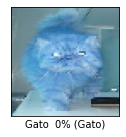

In [ ]:
  index_image=10
  plt.figure(figsize=(2,2))
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_val[index_image])

  predicted_label = "Gato" if predictions[index_image]<0.5 else "Perro"
  real_label="Gato" if Y_val[index_image]==0 else "Perro"
  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions[index_image]),
                                real_label))

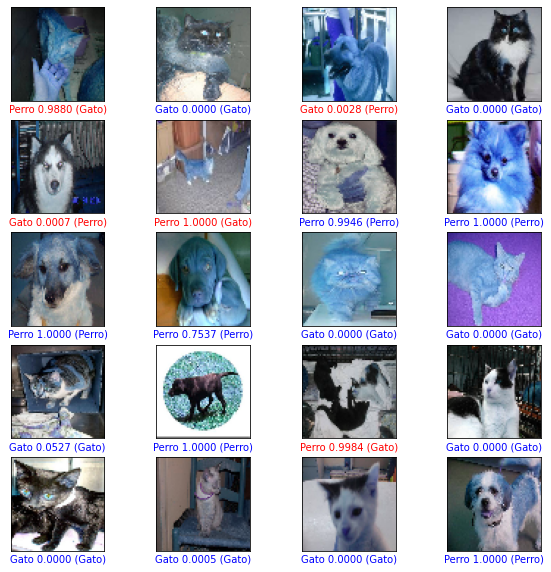

In [ ]:
plt.figure(figsize=(10,10))
for index_image in range(20):
  plt.subplot(5, 4, index_image+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_val[index_image])
  predicted_label = "Gato" if predictions[index_image]<0.5 else "Perro"
  real_label="Gato" if Y_val[index_image]==0 else "Perro"
  color= 'blue' if predicted_label == real_label else 'red'
  plt.xlabel(f'{predicted_label} {np.max(predictions[index_image]):.4f} ({real_label})', color=color)

Binarizar la salida de predicción

In [ ]:
predictions_label=[(0 if element<0.5 else 1) for element in predictions]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_val, predictions_label)

In [ ]:
classes = np.unique(Y_val)
classes

array([0, 1])

In [ ]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
print(accuracy, misclass)


0.791 0.20899999999999996


In [ ]:
cm

array([[2006,  519],
       [ 526, 1949]])

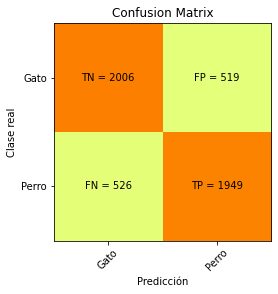

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Gato','Perro']
plt.title('Confusion Matrix')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()

El modelo que se usó en la otra clase, que es muy simple, no permite clasificar bien en este caso:

In [ ]:
import tensorflow as tf
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64,3)),
    # 128 neuronas con función de activación relu
    keras.layers.Dense(128, activation=tf.nn.relu),
    # 10 neuronas de salida con función de activación softmax
    keras.layers.Dense(2, activation=tf.nn.softmax) 
])

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history2=model.fit(train,labels_train, epochs = 5)

Epoch 1/5
782/782 [==============================] - 2s 3ms/step - loss: 0.9772 - acc: 0.5461
Epoch 2/5
782/782 [==============================] - 2s 3ms/step - loss: 0.6754 - acc: 0.5894
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 0.6546 - acc: 0.6139
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 0.6508 - acc: 0.6176
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 0.6445 - acc: 0.6233


## Un modelo más complejo

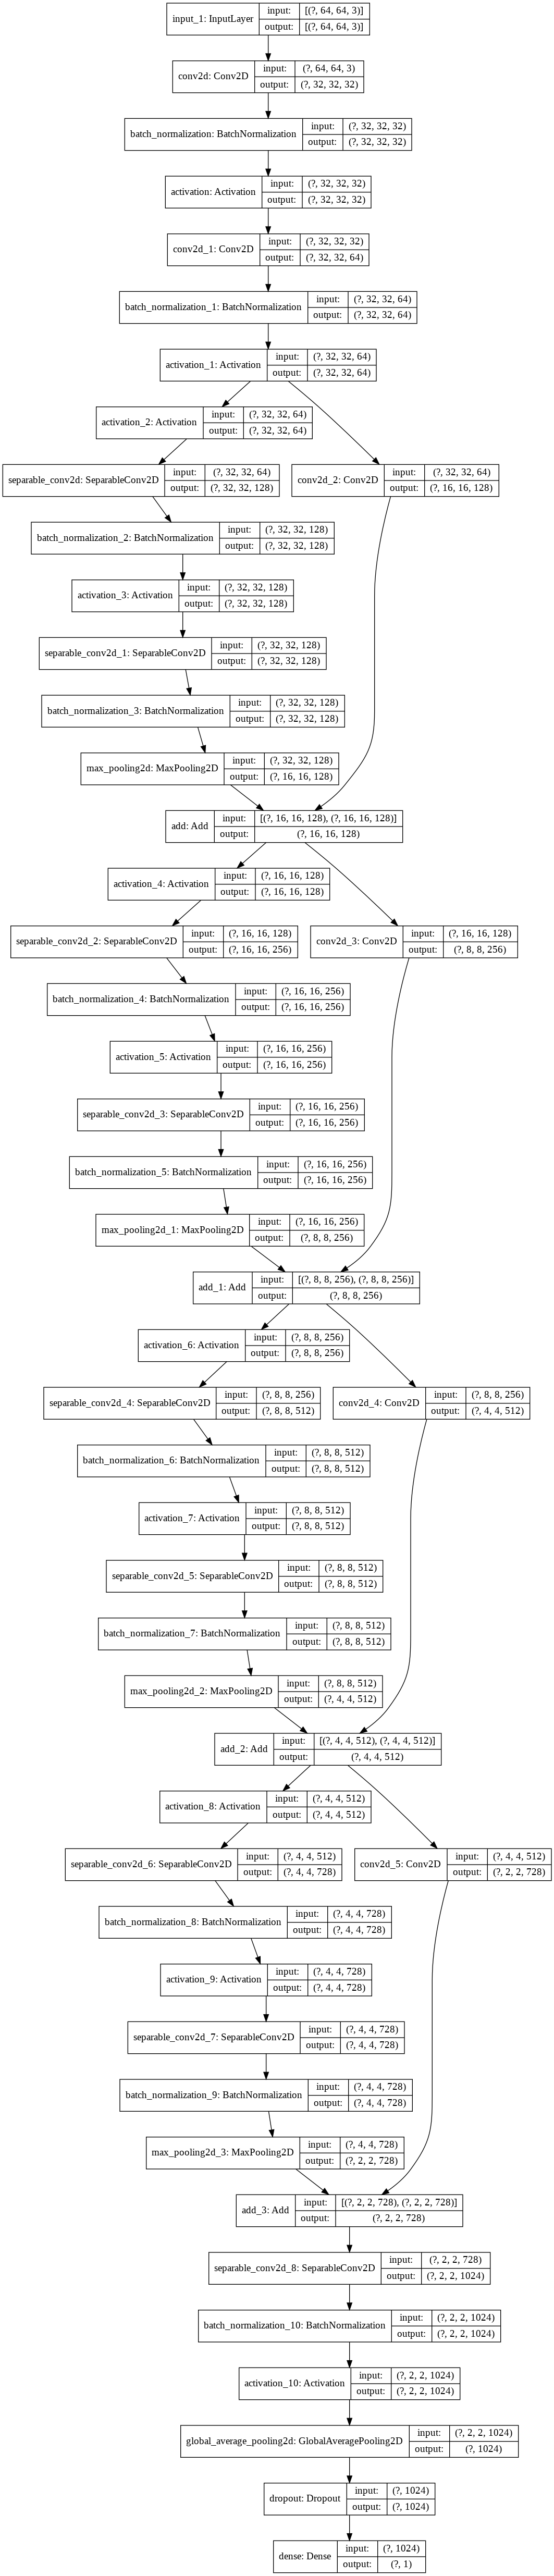

In [ ]:
input_shape=train.shape[1:4]
num_classes=2

inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x 

for size in [128, 256, 512, 728]:
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model= keras.Model(inputs, outputs)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("save_last_model.h5")]
history=model.fit(X_train,Y_train, epochs=20, callbacks=callbacks, validation_data=(X_val,Y_val)

Epoch 1/20
625/625 [==============================] - 21s 34ms/step - loss: 0.5767 - accuracy: 0.7047 - val_loss: 0.7983 - val_accuracy: 0.5920
Epoch 2/20
625/625 [==============================] - 21s 33ms/step - loss: 0.4220 - accuracy: 0.8079 - val_loss: 0.4197 - val_accuracy: 0.8086
Epoch 3/20
625/625 [==============================] - 21s 33ms/step - loss: 0.3477 - accuracy: 0.8435 - val_loss: 0.3575 - val_accuracy: 0.8384
Epoch 4/20
625/625 [==============================] - 21s 33ms/step - loss: 0.2838 - accuracy: 0.8792 - val_loss: 0.3651 - val_accuracy: 0.8360
Epoch 5/20
625/625 [==============================] - 21s 33ms/step - loss: 0.2398 - accuracy: 0.9011 - val_loss: 0.4015 - val_accuracy: 0.8170
Epoch 6/20
625/625 [==============================] - 21s 33ms/step - loss: 0.1958 - accuracy: 0.9200 - val_loss: 0.3865 - val_accuracy: 0.8346
Epoch 7/20
625/625 [==============================] - 21s 33ms/step - loss: 0.1732 - accuracy: 0.9304 - val_loss: 0.4074 - val_accuracy:

In [ ]:
model.evaluate(X_val,Y_val)

157/157 [==============================] - 2s 10ms/step - loss: 0.4762 - accuracy: 0.8630


[0.47624683380126953, 0.8629999756813049]

## Aumentar los datos
Aumentar los datos es una forma de incrementar los datos, con imágenes creadas a partir de las imagenes que ya tenemos con pequeñas variaciones.

Tenemos una clase ***ImageDataGenerator*** que se utiliza para generar lotes de datos de imagen tensoriales con aumento de datos en tiempo real. Los datos se colocarán en bucle (en lotes) de forma indefinida. Los datos de imagen se generan transformando las imágenes de entrenamiento reales por rotación, recorte, desplazamiento, corte, zoom, giro, reflexión, normalización, etc. 

In [ ]:
from tensorflow..keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(train)

In [ ]:
batch_size=128
epochs=50
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0]//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
156/156 [==============================] - 24s 154ms/step - loss: 0.6456 - accuracy: 0.6384 - val_loss: 0.6925 - val_accuracy: 0.5012
Epoch 2/50
156/156 [==============================] - 23s 146ms/step - loss: 0.5662 - accuracy: 0.7104 - val_loss: 0.7106 - val_accuracy: 0.4962
Epoch 3/50
156/156 [==============================] - 23s 145ms/step - loss: 0.5211 - accuracy: 0.7444 - val_loss: 0.7620 - val_accuracy: 0.5286
Epoch 4/50
156/156 [==============================] - 22s 144ms/step - loss: 0.4809 - accuracy: 0.7669 - val_loss: 0.6434 - val_accuracy: 0.6756
Epoch 5/50
156/156 [==============================] - 23s 145ms/step - loss: 0.4572 - accuracy: 0.7820 - val_loss: 0.5484 - val_accuracy: 0.7400
Epoch 6/50
156/156 [==============================] - 23s 144ms/step - loss: 0.4359 - accuracy: 0.7944 - val_loss: 0.4557 - val_accuracy: 0.8022
Epoch 7/50
156/156 [==============================] - 

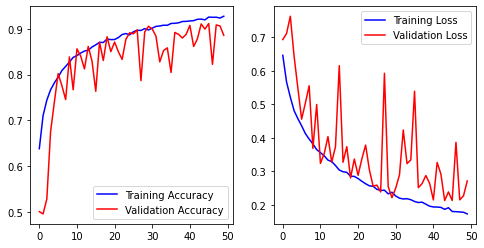

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Datos/dogcatsmodels.tf', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Datos/dogcatsmodels.tf/assets


In [ ]:
newmodel=keras.models.load_model('/content/drive/My Drive/Datos/dogcatsmodels.tf')

In [ ]:
model.evaluate(X_val,Y_val)

157/157 [==============================] - 1s 6ms/step - loss: 0.2715 - accuracy: 0.8858


[0.27151986956596375, 0.8858000040054321]

In [ ]:
newmodel.evaluate(X_val,Y_val)

157/157 [==============================] - 1s 6ms/step - loss: 0.2715 - accuracy: 0.8858


[0.27151986956596375, 0.8858000040054321]

Para guardar los pesos y un modelo h5, se puede:


```
model.save('my_model')  # Crea un fichero HDF5 'my_model.h5'
del model  # deletes the existing model
model = load_model('my_model') # Cargar modelo
model.save_weights('my_model_weights.h5') # Guardar pesos
model.load_weights('my_model_weights.h5') # Cargar pesos
```



## Transferencia de aprendizaje (usando otras redes entrenadas)

Lo mejor para cargar los datos es cargarlo por batch, pero para esto deben estar separadas en carpetas, que no es este caso.

Para separar las imágenes en carpetas con el nombre de las clases, vamos a crear carpetas y dividirlas

In [32]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
dataset_home = '/content/dataset_dogs_vs_cats/'

labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)

src_directory = '/content/train'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	if file.startswith('cat'):
		dst = dataset_home + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + 'dogs/'  + file
		copyfile(src, dst)

Para poder dividirlo en entrenamiento y validación, vamos a pasarlos con un aleatorio

In [30]:
dataset_home = '/content/data_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

seed(1)

val_ratio = 0.2
src_directory = '/content/train'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
batch_size=128
train_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/train', class_mode='binary', batch_size=batch_size, target_size=(224, 224))
test_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/test', class_mode='binary', batch_size=batch_size, target_size=(224, 224))

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [33]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
base_model=ResNet50(include_top=False, pooling='max', weights='imagenet')
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)
for layer in base_model.layers:
  layer.trainable = False
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
batch_size=128
epochs=50
#datagen = ImageDataGenerator()
#history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                              epochs = epochs, validation_data = (X_val,Y_val),
#                              verbose = 1, steps_per_epoch=X_train.shape[0]//batch_size)
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/50
156/156 [==============================] - 8s 52ms/step - loss: 0.7975 - accuracy: 0.8148 - val_loss: 0.3378 - val_accuracy: 0.8448
Epoch 2/50
156/156 [==============================] - 7s 45ms/step - loss: 0.2899 - accuracy: 0.8705 - val_loss: 0.3338 - val_accuracy: 0.8522
Epoch 3/50
156/156 [==============================] - 7s 46ms/step - loss: 0.2427 - accuracy: 0.8964 - val_loss: 0.3236 - val_accuracy: 0.8532
Epoch 4/50
156/156 [==============================] - 7s 46ms/step - loss: 0.1882 - accuracy: 0.9241 - val_loss: 0.3457 - val_accuracy: 0.8450
Epoch 5/50
156/156 [==============================] - 7s 45ms/step - loss: 0.1405 - accuracy: 0.9483 - val_loss: 0.3866 - val_accuracy: 0.8532
Epoch 6/50
156/156 [==============================] - 7s 45ms/step - loss: 0.0993 - accuracy: 0.9649 - val_loss: 0.3920 - val_accuracy: 0.8554
Epoch 7/50
156/156 [==============================] - 7s 45ms/step - loss: 0.0692 - accuracy: 0.9777 - val_loss: 0.4399 - val_accuracy: 0.8482

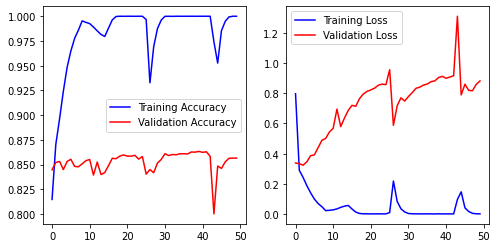

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD

In [ ]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=output)

opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size=128
epochs=50
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=10, verbose=1)

Epoch 1/5
156/156 [==============================] - 86s 548ms/step - loss: 0.1231 - accuracy: 0.9522 - val_loss: 0.1626 - val_accuracy: 0.9375
Epoch 2/5
156/156 [==============================] - 85s 546ms/step - loss: 0.1240 - accuracy: 0.9510 - val_loss: 0.1584 - val_accuracy: 0.9387
Epoch 3/5
156/156 [==============================] - 85s 543ms/step - loss: 0.1177 - accuracy: 0.9550 - val_loss: 0.1846 - val_accuracy: 0.9291
Epoch 4/5
156/156 [==============================] - 85s 546ms/step - loss: 0.1173 - accuracy: 0.9531 - val_loss: 0.1614 - val_accuracy: 0.9344
Epoch 5/5
156/156 [==============================] - 85s 545ms/step - loss: 0.1132 - accuracy: 0.9551 - val_loss: 0.2214 - val_accuracy: 0.9104


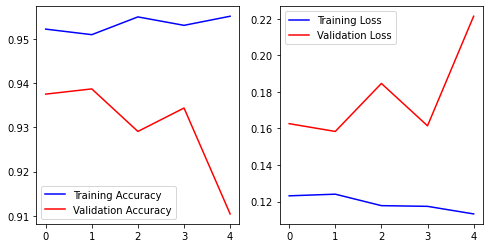

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf/assets


In [ ]:
model=keras.models.load_model('/content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf')

In [ ]:
## Para una sola imagen
def load_image(filename):
  img = image.load_img(filename, target_size=(224, 224))
  img = image.img_to_array(img)
  img = img.reshape(224, 224, 3)
  img = img.astype('float32')
  return img

In [ ]:
PATH='/content/data_dogs_vs_cats/test'
classes=os.listdir(PATH)
fnames_test=[]
labels_test=[]
for i,c in enumerate(classes):
  newimages=[f'{PATH}/{c}/{f}' for f in (os.listdir(f'{PATH}/{c}'))]
  fnames_test.extend(newimages)
  newlabels=[i]*len(newimages)
  labels_test.extend(newlabels) 

In [ ]:
X=[load_image(f) for f in fnames_test]
X=np.array(X)/255.0

In [ ]:
X.shape

(5090, 224, 224, 3)

In [ ]:
predictions = model.predict(X)

In [ ]:
predictions_label=[(0 if element<0.5 else 1) for element in predictions]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predictions_label)
cm

array([[2501,   50],
       [ 406, 2133]])

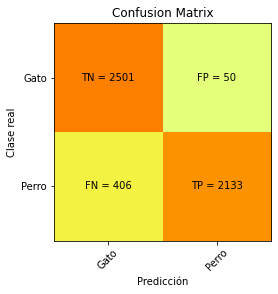

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Gato','Perro']
plt.title('Confusion Matrix')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()